# Ideas

* Backtesting: don't cross the spread, place limit orders in anticipation of a big price move
* Consider different time horizons via logsigs / conv layers with different kernels?
* Large spread should be a huge indicator. Also don't give up spread easily if it's huge
* Avoid very short holding peridos (smoothing, impact ideas)
* If short, don't sell on neutral signal, sell first on opposite signal (if nothing lost yet)
* Place limit orders: what is our anticipation? Expect large drop and rebound (and vice versa)?
* Which portion of the portfolio (Kelly, fixed proportion of your wealth)?
* Better smoothing of the strategy
* Incorporate information about market volatility
* Strategy should be based on my current inventory and pnl

# AB Test

* Ordering of the features: (ap, av, bp, bv) vs. (ap, bp, av, bv)
* Selectively remove features to check if they are significant

# To-Dos

* Never re-index / reset index: create method integrate that takes strategy and asset price paths and calculates pnl
* Proper scaling and transforms

In [54]:
import pandas as pd
from csv import writer
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import Model
from keras.layers import Input, LSTM, Conv1D, Conv2D, Reshape, Dense, BatchNormalization, Dropout, concatenate
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [113]:
# size of the time-series slice used as input to the NN
WINDOW_SIZE = 100

# offset for the rolling windows used for training
OFFSET = 5

# size of the smoothing kernel used to generate labels
KERNEL_SIZE = 50

# center of mass for smoothing the strategy
COM = 10

# labels are quantized into -1, 0, 1 based on this threshold
LABEL_THRESHOLD = 1e-5

In [114]:
apcs = [f'ap_{i}' for i in range(10)]
avcs = [f'av_{i}' for i in range(10)]
bpcs = [f'bp_{i}' for i in range(10)]
bvcs = [f'bv_{i}' for i in range(10)]

keys = [x for items in zip(apcs, bpcs, avcs, bvcs) for x in items]
features = ['bid_diff_feature_1', 'ask_diff_feature_1']

# Data

In [115]:
pd.set_option('max_rows', 100)

In [116]:
df = pd.read_csv('_input/data/20210712_000000.csv')[:20000]
df.index = pd.to_datetime(df['timestamp'] * 1000 * 1000)
df

,timestamp,best_bid_price,best_ask_price,estimated_delivery_price,index_price,mark_price,open_interest,settlement_price,change_id,ap_0,...,bp_7,bv_7,ap_8,av_8,bp_8,bv_8,ap_9,av_9,bp_9,bv_9
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-07-12 21:58:52.362,1626127132362,32870.0,32870.5,32883.12,32883.12,32873.38,340919370,34285.44,32936741408,32870.5,...,32861.5,81780.0,32879.5,190510.0,32860.0,1300.0,32880.0,2800.0,32859.0,4290.0
2021-07-12 21:58:52.619,1626127132619,32870.0,32870.5,32883.12,32883.12,32873.40,340919370,34285.44,32936741424,32870.5,...,32861.5,81780.0,32880.0,2800.0,32860.0,1300.0,32880.5,93240.0,32859.0,4290.0
2021-07-12 21:58:52.720,1626127132720,32870.0,32870.5,32883.12,32883.12,32873.40,340919370,34285.44,32936741472,32870.5,...,32861.5,81780.0,32880.0,2800.0,32860.0,1300.0,32880.5,93200.0,32859.0,4290.0
2021-07-12 21:58:52.931,1626127132931,32870.0,32870.5,32883.56,32883.56,32873.84,340919370,34285.44,32936741508,32870.5,...,32861.5,81780.0,32880.0,2800.0,32860.0,1300.0,32880.5,108040.0,32859.0,4290.0
2021-07-12 21:58:53.031,1626127133031,32870.0,32870.5,32883.56,32883.56,32873.84,340919370,34285.44,32936741550,32870.5,...,32861.5,81780.0,32879.5,190420.0,32860.0,1300.0,32880.0,2800.0,32859.0,4290.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-12 22:48:21.676,1626130101676,33045.5,33046.0,33055.07,33055.07,33047.39,342882300,34285.44,32937625906,33046.0,...,33040.0,72360.0,33054.5,100.0,33039.0,90.0,33055.0,100.0,33038.0,5000.0
2021-07-12 22:48:22.009,1626130102009,33045.5,33046.0,33055.07,33055.07,33047.42,342882300,34285.44,32937625930,33046.0,...,33040.0,72360.0,33054.5,100.0,33039.0,90.0,33055.0,100.0,33038.0,5000.0
2021-07-12 22:48:22.111,1626130102111,33045.5,33046.0,33055.07,33055.07,33047.42,342882300,34285.44,32937625966,33046.0,...,33039.0,90.0,33055.0,100.0,33038.0,2000.0,33055.5,21200.0,33036.5,63200.0


In [117]:
def prepare_df(df, k=KERNEL_SIZE):

    # diff time and asset price with lag=1 to remove trend
    df0 = df[['timestamp', 'best_bid_price', 'best_ask_price']].diff(1).rename(columns={'timestamp': 'timestamp_diff', 'best_bid_price': f'bid_diff_feature_1', 'best_ask_price': f'ask_diff_feature_1'})
    df0['timestamp_diff'] /= 1000.

    df1 = df[['best_bid_price', 'best_ask_price'] + keys]
    dfX = pd.concat([df1, df0], axis=1)

    # set prices as relative differences
    dfX[apcs] = dfX[apcs].sub(dfX['ap_0'], axis=0)
    dfX[bpcs] = -dfX[bpcs].sub(dfX['bp_0'], axis=0)

    # remove nans
    dfX = dfX[~dfX.isna().any(axis=1)]

    # rescale volumes
    l = 10.
    u = 1000000.
    dfX[avcs + bvcs] = (dfX[avcs + bvcs] - l) / (u - l)
    
    dfX['mid_price'] = (dfX['best_bid_price'] + dfX['best_ask_price']) / 2
    dfX['spread'] = dfX['best_ask_price'] - dfX['best_bid_price']

    # https://arxiv.org/pdf/1808.03668.pdf, p. 4
    dfX['m+'] = dfX['mid_price'].shift(-(k-1)).rolling(k).mean()
    dfX['m-'] = dfX['mid_price'].rolling(k).mean()
    dfX['y1'] = (dfX['m+'] - dfX['mid_price']) / dfX['mid_price']
    dfX['y2'] = (dfX['m+'] - dfX['m-']) / dfX['m-']

    dfX = dfX.iloc[k-1:-(k-1)]

    # reset index
    return dfX

dfX = prepare_df(df)
dfX[:10]

,best_bid_price,best_ask_price,ap_0,bp_0,av_0,bv_0,ap_1,bp_1,av_1,bv_1,...,bv_9,timestamp_diff,bid_diff_feature_1,ask_diff_feature_1,mid_price,spread,m+,m-,y1,y2
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-07-12 21:58:59.869,32874.0,32874.5,0.0,-0.0,0.00735,0.01316,2.0,4.0,0.00219,0.04642,...,0.00336,0.060,0.0,0.0,32874.25,0.5,32872.25,32873.21,-0.000061,-0.000029
2021-07-12 21:59:00.097,32874.0,32874.5,0.0,-0.0,0.00215,0.01316,2.0,4.0,0.00219,0.04642,...,0.00336,0.228,0.0,0.0,32874.25,0.5,32872.17,32873.29,-0.000063,-0.000034
2021-07-12 21:59:00.177,32874.0,32874.5,0.0,-0.0,0.00215,0.01316,2.0,4.0,0.00219,0.04642,...,0.00336,0.080,0.0,0.0,32874.25,0.5,32872.09,32873.37,-0.000066,-0.000039
2021-07-12 21:59:00.303,32874.0,32874.5,0.0,-0.0,0.00215,0.01316,2.0,4.0,0.00219,0.04642,...,0.00336,0.126,0.0,0.0,32874.25,0.5,32872.01,32873.45,-0.000068,-0.000044
2021-07-12 21:59:00.354,32874.0,32874.5,0.0,-0.0,0.00215,0.01316,2.0,4.0,0.00219,0.04642,...,0.00259,0.051,0.0,0.0,32874.25,0.5,32871.93,32873.53,-0.000071,-0.000049
2021-07-12 21:59:00.522,32874.0,32874.5,0.0,-0.0,0.00215,0.01316,2.0,4.0,0.00219,0.04642,...,0.00119,0.168,0.0,0.0,32874.25,0.5,32871.85,32873.61,-0.000073,-0.000054
2021-07-12 21:59:00.616,32874.0,32874.5,0.0,-0.0,0.00215,0.01316,2.0,4.0,0.00219,0.04642,...,0.01505,0.094,0.0,0.0,32874.25,0.5,32871.77,32873.69,-0.000075,-0.000058
2021-07-12 21:59:00.869,32874.0,32874.5,0.0,-0.0,0.00215,0.01316,2.0,3.5,0.00219,0.00099,...,0.01505,0.253,0.0,0.0,32874.25,0.5,32871.69,32873.77,-0.000078,-0.000063
2021-07-12 21:59:01.070,32874.0,32874.5,0.0,-0.0,0.00215,0.03126,2.0,3.5,0.00219,0.00099,...,0.01505,0.201,0.0,0.0,32874.25,0.5,32871.61,32873.85,-0.000080,-0.000068


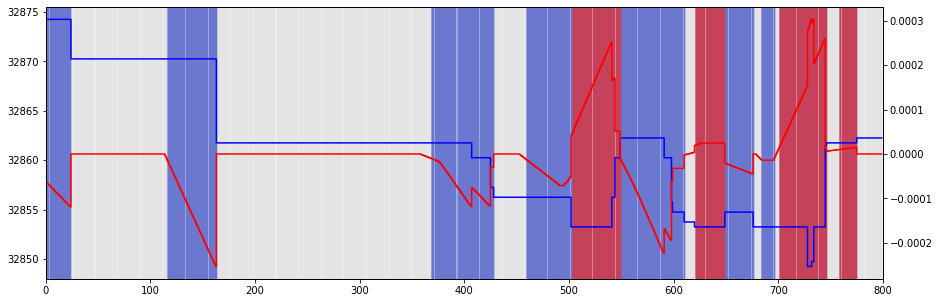

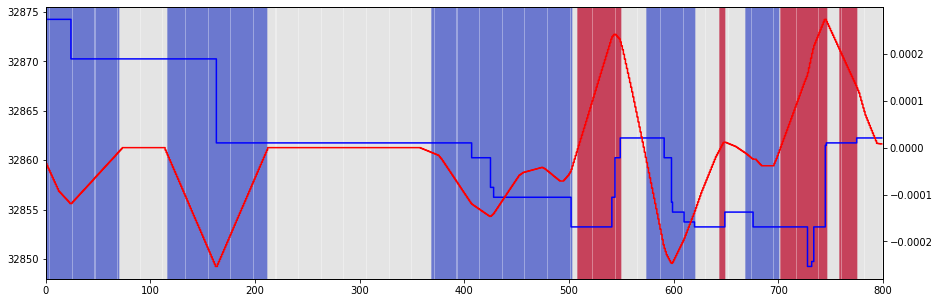

In [118]:
N0, N1 = 0, 800

for label in 'y1', 'y2':

    plt.figure(figsize=(15, 5))

    # colors
    cs = -1 + 1. * (dfX.iloc[N0:N1][label] > -LABEL_THRESHOLD) + 1. * (dfX.iloc[N0:N1]['y1'] > LABEL_THRESHOLD)
    cs = cs.to_numpy().reshape(1, -1)
    plt.pcolor(cs, cmap='coolwarm', alpha=0.5, linewidths=0)
    plt.yticks([])
    
    # price
    plt.twinx().step(np.arange(N1-N0), dfX.iloc[N0:N1]['mid_price'], c='b')

    # label
    plt.twinx().step(np.arange(N1-N0), dfX.iloc[N0:N1][label], c='r')


In [119]:
def split(df, offset, window_size):
    
    threshold = 5e-5
    
    # X1
    X1 = np.array([df.iloc[i*offset:i*offset+window_size][keys] for i in range((len(df) - window_size) // offset)])
    X1 = X1[:, :, :, np.newaxis]
    
    # X2
    X2 = np.array([df.iloc[i*offset:i*offset+window_size][features] for i in range((len(df) - window_size) // offset)])
    
    # y
    y = dfX.iloc[offset-1+window_size:len(df):offset]['y2'].to_numpy()
    y = -1 + 1. * (y >= -threshold) + 1. * (y >= threshold)
    
    # one-hot encoder
    enc = OneHotEncoder(sparse=False)
    y = enc.fit_transform(y.reshape(-1, 1))

    return X1, X2, y

(array([1221.,    0.,    0.,    0.,    0., 1296.,    0.,    0.,    0.,
        1443.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

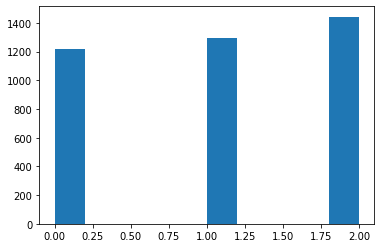

In [120]:
X1, X2, y = split(dfX, OFFSET, WINDOW_SIZE)
plt.hist(np.argmax(1+y, axis=1))

In [121]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.15)

# Build model

In [124]:
def build_model(window_size):

    input_layer1 = Input(shape=(window_size, 40, 1))
    input_layer2 = Input(shape=(window_size, len(features)))

    x = Conv2D(16, kernel_size=(1, 2), strides=(1, 2), activation='relu')(input_layer1)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)
    
    x = Conv2D(16, kernel_size=(1, 2), strides=(1, 2), activation='relu')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)
    
    x = Conv2D(16, kernel_size=(1, 10), activation='relu')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)

    x = Reshape((window_size, -1))(x)

    x = concatenate([x, input_layer2])

    lstm_layer = LSTM(64)(x)
    bn_layer = BatchNormalization()(lstm_layer)
    dropout_layer = Dropout(0.8)(bn_layer)
    output_layer = Dense(3, activation='softmax')(dropout_layer)

    model = Model([input_layer1, input_layer2], output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [125]:
model = build_model(window_size=WINDOW_SIZE)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 100, 40, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 100, 20, 16)  48          input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 100, 20, 16)  1040        conv2d_54[0][0]                  
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 100, 20, 16)  1040        conv2d_55[0][0]                  
____________________________________________________________________________________________

In [126]:
cp_callback = ModelCheckpoint(filepath='_output/model.h5', monitor='val_accuracy', save_weights_only=True, save_best_only=True)
history = model.fit([X1_train, X2_train], y_train, epochs=30, batch_size=32, validation_split=0.15, callbacks=[cp_callback], verbose=2)

Epoch 1/30
90/90 - 15s - loss: 1.2316 - accuracy: 0.4698 - val_loss: 1.0359 - val_accuracy: 0.4713
Epoch 2/30
90/90 - 15s - loss: 1.1130 - accuracy: 0.5281 - val_loss: 1.0223 - val_accuracy: 0.4673
Epoch 3/30
90/90 - 11s - loss: 1.0281 - accuracy: 0.5463 - val_loss: 0.9766 - val_accuracy: 0.5960
Epoch 4/30
90/90 - 10s - loss: 0.9522 - accuracy: 0.5781 - val_loss: 0.9977 - val_accuracy: 0.5168
Epoch 5/30
90/90 - 10s - loss: 0.9378 - accuracy: 0.5844 - val_loss: 0.9449 - val_accuracy: 0.5010
Epoch 6/30
90/90 - 11s - loss: 0.9424 - accuracy: 0.5739 - val_loss: 0.9750 - val_accuracy: 0.4792
Epoch 7/30
90/90 - 13s - loss: 0.9277 - accuracy: 0.5841 - val_loss: 0.8363 - val_accuracy: 0.5941
Epoch 8/30
90/90 - 11s - loss: 0.8886 - accuracy: 0.5928 - val_loss: 0.8656 - val_accuracy: 0.5604
Epoch 9/30
90/90 - 11s - loss: 0.9179 - accuracy: 0.5977 - val_loss: 1.1162 - val_accuracy: 0.4198
Epoch 10/30
90/90 - 14s - loss: 0.8984 - accuracy: 0.5963 - val_loss: 1.3716 - val_accuracy: 0.3663
Epoch 11/

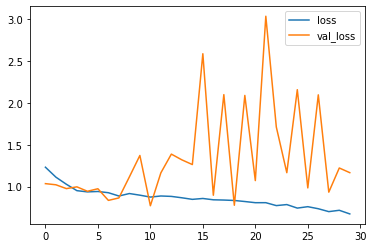

In [127]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [128]:
# load and evaluate best model

model.load_weights('_output/model.h5')

loss, accuracy = model.evaluate([X1_test, X2_test], y_test, verbose=0)

print(f"{'loss':15}{loss:7.4f}")
print(f"{'accuracy':15}{accuracy:7.4f}")

y_pred_num = np.argmax(model.predict([X1_test, X2_test]), axis=1)
y_test_num = np.argmax(y_test, axis=1)

precision, recall, fscore, support = precision_recall_fscore_support(y_pred_num, y_test_num)

print(f"{'precision':15}{' '.join(['{:7.2f}'.format(x) for x in precision])}")
print(f"{'recall':15}{' '.join(['{:7.2f}'.format(x) for x in recall])}")
print(f"{'fscore':15}{' '.join(['{:7.2f}'.format(x) for x in fscore])}")
print(f"{'support':15}{' '.join(['{:7}'.format(x) for x in support])}")


loss            0.8489
accuracy        0.6178
precision         0.52    0.64    0.69
recall            0.73    0.52    0.65
fscore            0.60    0.57    0.67
support            143     232     219


# Backtest

In [129]:
def create_strategy(df):
    
    # load backtest dataset
    dfY = prepare_df(df)

    # predict returns
    X1, X2, _ = split(dfY, 1, WINDOW_SIZE)
    ret_pred = model.predict([X1, X2])
    strategy = np.argmax(ret_pred, axis=1) - 1.

    # calculating ewm strategy
    retval_df = dfY[['timestamp_diff', 'best_bid_price', 'best_ask_price', 'y2']].copy()
    retval_df.loc[retval_df.index[WINDOW_SIZE:], 'strategy'] = strategy.reshape(-1)
    retval_df.loc[retval_df.index[WINDOW_SIZE:], 'ewm_strategy_10'] = np.round(retval_df['strategy'].ewm(com=COM).mean())

    return retval_df

In [314]:
df = pd.read_csv('_input/data/20210714_182011.csv')[30000:35000]
df.index = pd.to_datetime(df['timestamp']*1000*1000)

dff = create_strategy(df)
#dff.style.background_gradient(cmap='coolwarm', subset=(dff.index, ['y2', 'strategy', 'ewm_strategy_10']))

In [131]:
def integrate(df, strategy_column, bid_column='best_bid_price', ask_column='best_ask_price'):

    money = df[bid_column] * np.maximum(dff[strategy_column].fillna(0).diff(-1).shift(1), 0)
    money += df[ask_column] * np.minimum(dff[strategy_column].fillna(0).diff(-1).shift(1), 0)
    pnl = np.cumsum(money) + df[strategy_column] * df[bid_column]
    
    retval_df = df[[bid_column, ask_column, strategy_column]].copy().rename(columns={bid_column: 'bid', ask_column: 'ask', strategy_column: 'strategy'})
    retval_df['money'] = money
    retval_df['pnl'] = pnl
    
    return retval_df


100%|██████████| 38/38 [01:32<00:00,  2.43s/it]

11.5 36.02009672975702
11.5


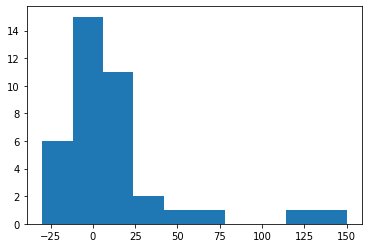

In [142]:
df = pd.read_csv('_input/data/20210714_182011.csv')
df.index = pd.to_datetime(df['timestamp']*1000*1000)

pnls = []

STEP = 1000

for i in tqdm(np.arange(0, 38000, STEP)):
    dff = create_strategy(df[i:i+STEP])
    int_df = integrate(dff, 'ewm_strategy_10')
    pnls += [int_df.iloc[-1]['pnl']]
    
plt.hist(pnls)
print(np.mean(pnls), np.std(pnls))

# edge
p = np.mean(pnls)
print(p)

In [334]:
def plot_strategy_and_pnl(df):

    fig, ax = plt.subplots(figsize=(15, 10), nrows=2)

    df0 = df[~df.isna().any(axis=1)]

    height = (df0['best_bid_price'].max() - df0['best_bid_price'].min()) * 0.1
    X = np.repeat(np.arange(len(df0) + 1).reshape(1, -1), 2, axis=0)
    Y = np.repeat([[0, height]], len(df0) + 1, axis=0).T + df0['best_bid_price'].min() - 2 * height
    ax[0].pcolor(X, Y, df0[['ewm_strategy_10']].to_numpy().T, cmap='coolwarm', alpha=1.)
    ax[0].step(np.arange(len(df0)), df0['best_bid_price'].to_numpy(), c='b')

    int_df = integrate(df, 'ewm_strategy_10')
    int_df = int_df[~int_df.isna().any(axis=1)]
    height = (int_df['pnl'].max() - int_df['pnl'].min()) * 0.1
    X = np.repeat(np.arange(len(df0) + 1).reshape(1, -1), 2, axis=0)
    Y = np.repeat([[0, height]], len(df0) + 1, axis=0).T + int_df['pnl'].min() - 2 * height
    ax[1].pcolor(X, Y, df0[['ewm_strategy_10']].to_numpy().T, cmap='coolwarm', alpha=1.)
    ax[1].step(np.arange(len(int_df)), int_df['pnl'].to_numpy(), c='r')

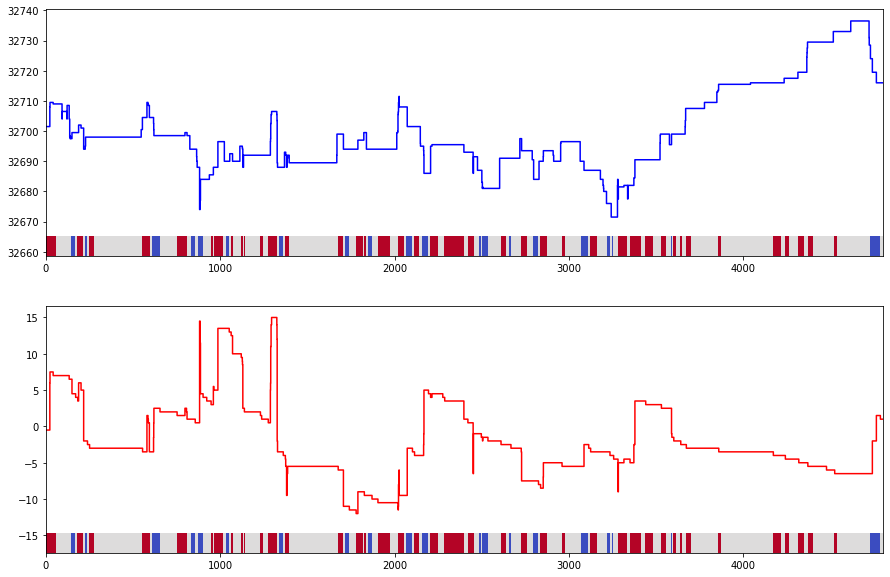

In [335]:
plot_strategy_and_pnl(dff)